In [2]:
# 전처리를 위해서 필요한 모듈들 가져오기
import requests 
import pandas as pd
import matplotlib.pyplot as plt #
import seaborn as sns #시각화를 위한 seaborn
import re #crawling시 parsing을 정규식으로 진행
#import ssl
import csv
#ssl._create_default_https_context = ssl._create_unverified_context
import warnings
warnings.filterwarnings('ignore')
from bs4 import *
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble._forest import RandomForestRegressor,ExtraTreesRegressor
from sklearn.ensemble._gb import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import time
import datetime

In [3]:
def verbose(f):
    def wrapper(*args):
        start=time.time()
        output = f(*args)
        print(f"{args[1]}의 실행 시간은: {time.time() - start}")
        return output
    return wrapper


In [4]:
# 한글 폰트
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

plt.rc('font', family='NanumBarunGothic') 

'sudo'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.
'sudo'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.
'rm'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


In [5]:
class Prepro():
    def __init__(self):
        self.df = pd.DataFrame(columns=['평균기온', '최고기온', '최저기온', '평균운량', '일강수량'])
    def weather_crawling(self,year,month):
        web_url = "https://www.weather.go.kr/w/obs-climate/land/past-obs/obs-by-day.do?stn=108&yy="+str(year)+"&mm="+str(month)+"&obs=1"
        # 크롤링으로 데이터 가져오기
        req = requests.get(web_url, headers={"User-agent":"Mozilla/5.0"})
        soup = BeautifulSoup(req.text, 'html.parser')
        trList = list(map(lambda x:x.get_text(), soup.find_all('tr')))

        # 데이터 예쁘게 깎아서 담기
        days, data = [], []
        for row in trList[5::2]:
            data.extend([float(*re.findall(r'\d+.\d+', item)) for item in row.split('\n') if len(item) and item != '\xa0'])
        for row in trList[4::2]:
            days.extend(["%d-%02d-" % (year, month) + "%02d" % int(item[:-1]) 
                         for item in row.split('\n') if len(item) and item != '\xa0'])
            # days.extend([str(year) + "-" + "%02d" % month +"-" + "%02d" % int(item[:-1]) for item in row.split('\n') if len(item) and item != '\xa0'])
        # 판다스 데이터프레임에 담고 출력. 이건 주피터노트북 환경이라 df 했는데, .py에선 print(df) 해줘야함
        tmp_df = pd.DataFrame(index=days, columns=['평균기온', '최고기온', '최저기온', '평균운량', '일강수량'])
        tmp_df['평균기온'] = data[0::5]
        tmp_df['최고기온'] = data[1::5]
        tmp_df['최저기온'] = data[2::5]
        tmp_df['평균운량'] = data[3::5]
        tmp_df['일강수량'] = data[4::5]
        self.df = pd.concat([self.df,tmp_df], axis = 0)
        return self.df
    
    def read_bicylce(self,path,total_bicycle):
        f = open(path, 'r')
        bicycle = csv.reader(f, delimiter=' ')
        for row in bicycle:
            date = row[0].split(",")[0]
            usage = row[0].split(",")[1]
            self.df.loc[date,"대여율"] = int(usage)
        for index in self.df.index:
            self.df.loc[index, '대여율'] /= total_bicycle[index.split('-')[0]] / 100
        return self.df
 

In [6]:
preprocessed = Prepro()
for month in range(3,13):
    preprocessed.weather_crawling(2020, month)
    #weather_df = pd.concat([weather_df,Prepro.weather_crawling(2020, month)], axis = 0)
for month in range(1, 13):
    preprocessed.weather_crawling(2021, month)
    #weather_df = pd.concat([weather_df,Prepro.weather_crawling(2021, month)], axis = 0)
for month in range(1, 7):
    preprocessed.weather_crawling(2022, month)
    #weather_df = pd.concat([weather_df,Prepro.weather_crawling(2022, month)], axis = 0)

total_bicycle = {'2020': 37500.0, '2021': 40500.0, '2022': 41500.0}
preprocessed.read_bicylce("서울특별시 공공자전거 일별 대여건수_2020.03_부터_2022.06.csv",total_bicycle)
preprocessed.df.head()

,평균기온,최고기온,최저기온,평균운량,일강수량,대여율
2020-03-01,5.8,10.1,3.2,8.1,0.2,65.149333
2020-03-02,3.4,7.6,0.0,1.6,0.0,97.709333
2020-03-03,4.8,10.5,0.3,6.5,0.0,105.192000
2020-03-04,2.2,4.6,1.3,5.1,0.0,83.384000
2020-03-05,1.4,6.3,2.8,0.0,0.0,95.602667


In [7]:
df = preprocessed.df.copy(deep=True)

In [8]:
class Visualization():
    @staticmethod
    def get_corr(df):
            pearson_df = df.corr('pearson')
            sns.clustermap(pearson_df, annot = True,      # 실제 값 화면에 나타내기
            cmap = 'RdYlBu_r',  # Red, Yellow, Blue 색상으로 표시
            vmin = -1, vmax = 1, #컬러차트 -1 ~ 1 범위로 표시
            )
    @staticmethod
    def get_scatter(df):
        id = 1
        plt.figure(figsize=(15,15))
        for i in df.columns.difference(["대여율"]):
            plt.subplot(3, 3, id)  
            plt.scatter(df[i], df["대여율"])
            plt.title(f"{i}와 대여율 scatter")
            id += 1
        plt.show()
    @staticmethod
    def standard_scaler(df,column_name):
        temp_mean = df[column_name].mean()
        temp_std = df[column_name].std()
        df[f"{column_name}_standard"]=(df[column_name]-temp_mean)/temp_std
        return df
    @staticmethod
    def min_max_scaler(df,column_name):
        temp_max = df[column_name].max()
        temp_min = df[column_name].min()
        df[f"{column_name}_minmax"]=(df[column_name]-temp_min)/(temp_max-temp_min)
        return df

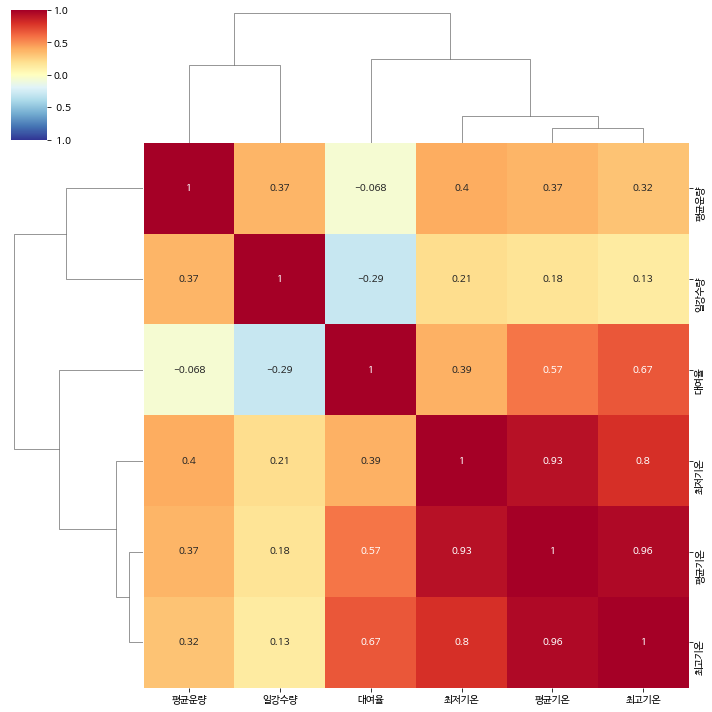

In [9]:
Visualization.get_corr(df)

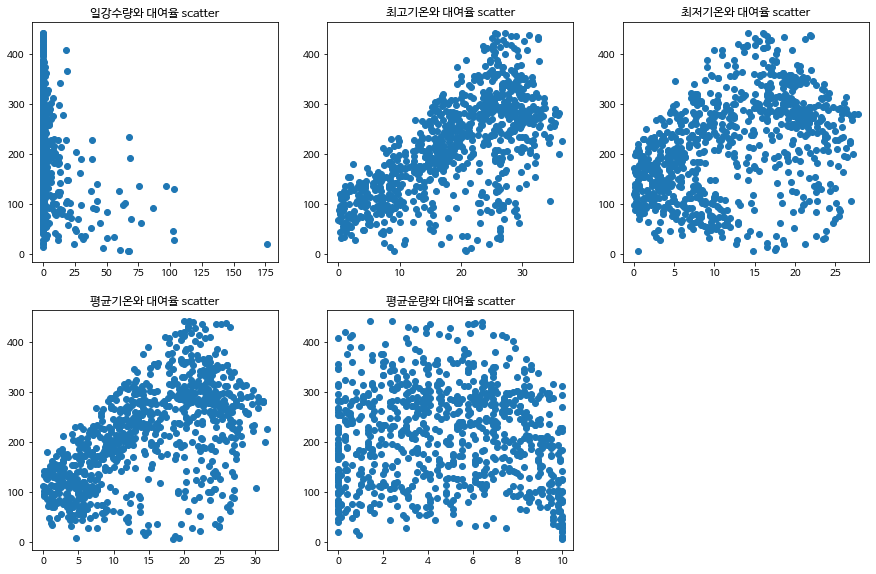

In [10]:
Visualization.get_scatter(df)

In [20]:
df.loc[df['일강수량'] >=15, "일강수량"] = 15
df.loc[df['일강수량'] < 15, "일강수량"] = 0
df

,평균기온,최고기온,최저기온,평균운량,일강수량,대여율,최고기온_minmax,최고기온_standard
2020-03-01,5.8,10.1,3.2,8.1,0.0,65.149333,0.276712,-0.914485
2020-03-02,3.4,7.6,0.0,1.6,0.0,97.709333,0.208219,-1.179542
2020-03-03,4.8,10.5,0.3,6.5,0.0,105.192000,0.287671,-0.872076
2020-03-04,2.2,4.6,1.3,5.1,0.0,83.384000,0.126027,-1.497611
2020-03-05,1.4,6.3,2.8,0.0,0.0,95.602667,0.172603,-1.317372
...,...,...,...,...,...,...,...,...
2022-06-26,26.5,28.1,24.8,10.0,0.0,295.118072,0.769863,0.993928
2022-06-27,26.8,28.1,25.4,10.0,0.0,228.339759,0.769863,0.993928
2022-06-28,26.9,27.9,25.7,10.0,0.0,269.886747,0.764384,0.972723
2022-06-29,25.1,26.1,24.4,10.0,15.0,126.901205,0.715068,0.781882


In [15]:
Visualization.min_max_scaler(df,"최고기온")
Visualization.standard_scaler(df,"최고기온")
Visualization.min_max_scaler(df,"최저기온")
Visualization.standard_scaler(df,"최저기온")
Visualization.min_max_scaler(df,"평균기온")
Visualization.standard_scaler(df,"평균기온")
df.head()

,평균기온,최고기온,최저기온,평균운량,일강수량,대여율,최고기온_minmax,최고기온_standard,최저기온_minmax,최저기온_standard,평균기온_minmax,평균기온_standard
2020-03-01,5.8,10.1,3.2,8.1,0.2,65.149333,0.276712,-0.914485,0.115108,-1.135732,0.182965,-1.046193
2020-03-02,3.4,7.6,0.0,1.6,0.0,97.709333,0.208219,-1.179542,0.000000,-1.554665,0.107256,-1.329272
2020-03-03,4.8,10.5,0.3,6.5,0.0,105.192000,0.287671,-0.872076,0.010791,-1.515390,0.151420,-1.164142
2020-03-04,2.2,4.6,1.3,5.1,0.0,83.384000,0.126027,-1.497611,0.046763,-1.384474,0.069401,-1.470811
2020-03-05,1.4,6.3,2.8,0.0,0.0,95.602667,0.172603,-1.317372,0.100719,-1.188099,0.044164,-1.565171


In [16]:
class Trainer():
    def __init__(self,df):
        self.df = df.copy(deep=True)
        self.Y = self.df["대여율"]
        self.X = self.df.drop(columns = ["대여율"])
        self.model_list = []
    def train_test(self,*args):
        self.X.drop(columns = list(args),inplace=True)
        
    @verbose
    def model_fit(self,model):
        model = model()
        model.fit(self.X,self.Y)
        return model
    def model_eval(self,model):
        print(f"{model}모델의 설명력은 {model.score(self.X,self.Y)}입니다")
        predict = model.predict(self.X)
        print(f"{model}모델의 rmse 값은 {mean_squared_error(self.Y,predict, squared=False)}입니다\n")
    def ensemble(self,*args):
        predict = 0
        i = 0
        for model in args:
            predict+=model.predict(self.X)
            i +=1
            self.model_list.append(model)
        print(f"모델 앙상블 결과 rmse는 값은 {mean_squared_error(self.Y,predict/i, squared=False)}입니다")
        return self.model_list

In [17]:
trainer = Trainer(df)
trainer.train_test("평균운량","최고기온","최저기온","평균기온","최고기온_minmax","최저기온_minmax","평균기온_minmax")

In [18]:
trainer.X.head()

,일강수량,최고기온_standard,최저기온_standard,평균기온_standard
2020-03-01,0.2,-0.914485,-1.135732,-1.046193
2020-03-02,0.0,-1.179542,-1.554665,-1.329272
2020-03-03,0.0,-0.872076,-1.515390,-1.164142
2020-03-04,0.0,-1.497611,-1.384474,-1.470811
2020-03-05,0.0,-1.317372,-1.188099,-1.565171


In [19]:
rf_model = trainer.model_fit(RandomForestRegressor)
trainer.model_eval(rf_model)
et_model = trainer.model_fit(ExtraTreesRegressor)
trainer.model_eval(et_model)
gbr_model = trainer.model_fit(GradientBoostingRegressor)
trainer.model_eval(gbr_model)

<class 'sklearn.ensemble._forest.RandomForestRegressor'>의 실행 시간은: 0.3331298828125
RandomForestRegressor()모델의 설명력은 0.959308294198875입니다
RandomForestRegressor()모델의 rmse 값은 19.711137068493883입니다

<class 'sklearn.ensemble._forest.ExtraTreesRegressor'>의 실행 시간은: 0.22248363494873047
ExtraTreesRegressor()모델의 설명력은 0.9999903299141957입니다
ExtraTreesRegressor()모델의 rmse 값은 0.303860252124256입니다

<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>의 실행 시간은: 0.08477258682250977
GradientBoostingRegressor()모델의 설명력은 0.8377237684935424입니다
GradientBoostingRegressor()모델의 rmse 값은 39.36281842213552입니다



In [20]:
model_list = trainer.ensemble(rf_model,et_model,gbr_model)

모델 앙상블 결과 rmse는 값은 19.309312833662947입니다


In [24]:
class Predictor():
    def __init__(self,df):
        self.df = df
        self.average = 0
        self.target_list=[]
    def average_weather(self):
        date = input("대여율을 예측하려는 날짜의 달과 일을 입력하세요: ")
        min_date = datetime.datetime.strptime("20200301", "%Y%m%d")
        max_date = datetime.datetime.strptime("20220630", "%Y%m%d")
        for i in range(2020,2023):
            target = datetime.datetime.strptime(str(i)+str(date), "%Y%m%d")
            if ((min_date - target).days <=0 and (max_date - target).days >= 0):
                self.target_list.append(target.strftime('%Y-%m-%d'))
        self.average = self.df.loc[self.target_list].mean(axis=0)
        return self.average
    def predict(self,model_list):
        predict = 0
        i = 0            
        for model in model_list:
            predict+=model.predict(self.average.values.reshape(1,-1))
            i +=1
        print(f"{self.target_list[0][5:7]}월 {self.target_list[0][8:10]}일의 따릉이 예측 따릉이 대여율은 {(predict/3)[0]:.2f}입니다")

In [25]:
predictor = Predictor(trainer.X)
average=predictor.average_weather()
predictor.predict(model_list)

대여율을 예측하려는 날짜의 달과 일을 입력하세요: 67
06월 07일의 따릉이 예측 따릉이 대여율은 341.22입니다
